<a href="https://colab.research.google.com/github/escuccim/vaegan-pytorch/blob/master/VAEGAN_Basic_80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Versions:
 - 3 : Took VAE-GAN code from GitHub and increased image size from 64x64 to 160x160, added aux classifier, output and loss
    

In [2]:
!nvidia-smi

Mon Dec 23 10:07:59 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt, colors
%matplotlib inline
import zipfile
import os
import matplotlib.animation as animation
import torchvision.utils as vutils
import numpy as np
import re
import random
import pandas as pd
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch import Tensor
from torch.optim import RMSprop,Adam,SGD
from torch.optim.lr_scheduler import ExponentialLR,MultiStepLR
from torchvision.utils import make_grid
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.optim import RMSprop,Adam,SGD
from torch.optim.lr_scheduler import ExponentialLR,MultiStepLR
from torchvision.utils import make_grid
from sklearn.metrics import f1_score
import torchvision.utils as vutils
from collections import OrderedDict
from torch.hub import load_state_dict_from_url

from google.colab import auth
auth.authenticate_user()

# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'gan-faces'

!gcloud config set project {project_id}

Updated property [core/project].


In [0]:
model_save_path = "vaegan_basic_80a.pt"
disc_opt_save_path = "vaegan_basic_80a_disc.pt"
enc_opt_save_path = "vaegan_basic_80a_enc.pt"
dec_opt_save_path = "vaegan_basic_80a_opt.pt"

In [5]:
if not os.path.exists(model_save_path):
  !gsutil cp gs://{bucket_name}/{model_save_path} ./{model_save_path} 
  !gsutil cp gs://{bucket_name}/{disc_opt_save_path} ./{disc_opt_save_path} 
  !gsutil cp gs://{bucket_name}/{dec_opt_save_path} ./{dec_opt_save_path} 
  !gsutil cp gs://{bucket_name}/{enc_opt_save_path} ./{enc_opt_save_path} 

Copying gs://gan-faces/vaegan_basic_80a.pt...
/ [1 files][172.7 MiB/172.7 MiB]                                                
Operation completed over 1 objects/172.7 MiB.                                    
Copying gs://gan-faces/vaegan_basic_80a_disc.pt...
\ [1 files][ 60.4 MiB/ 60.4 MiB]                                                
Operation completed over 1 objects/60.4 MiB.                                     
Copying gs://gan-faces/vaegan_basic_80a_opt.pt...
\ [1 files][ 41.7 MiB/ 41.7 MiB]                                                
Operation completed over 1 objects/41.7 MiB.                                     
Copying gs://gan-faces/vaegan_basic_80a_enc.pt...
\ [1 files][ 70.5 MiB/ 70.5 MiB]                                                
Operation completed over 1 objects/70.5 MiB.                                     


In [19]:
if not os.path.exists("celeba-dataset.zip"):
#   !kaggle datasets download -d jessicali9530/celeba-dataset
  !gsutil cp gs://{bucket_name}/celeba-dataset.zip ./celeba-dataset.zip
  zip_ref = zipfile.ZipFile('celeba-dataset.zip', 'r')
  zip_ref.extractall('data')
  zip_ref.close()

  zip_ref = zipfile.ZipFile('data/img_align_celeba.zip', 'r')
  zip_ref.extractall('data/images')
  zip_ref.close()

if not os.path.exists("imdb_crop_good.zip"):
  !gsutil cp gs://{bucket_name}/imdb_crop_good.zip ./ 
  zip_ref = zipfile.ZipFile('imdb_crop_good.zip', 'r')
  zip_ref.extractall('data/images/imdb_images')
  zip_ref.close()  

# if not os.path.exists("celeb_a_good.zip"):
# #   !kaggle datasets download -d jessicali9530/celeba-dataset
#   !gsutil cp gs://{bucket_name}/celeb_a_good.zip ./celeb_a_good.zip
#   zip_ref = zipfile.ZipFile('celeb_a_good.zip', 'r')
#   zip_ref.extractall('data/images/celeb_a')
#   zip_ref.close()

if not os.path.exists("Training_Pictures.zip"):
  !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
  zip_ref = zipfile.ZipFile('Training_Pictures.zip', 'r')
  zip_ref.extractall('data/images/training')
  zip_ref.close()

if not os.path.exists("wiki_images_good.zip"):
  !gsutil cp gs://{bucket_name}/wiki_images_good.zip ./wiki_images_good.zip
  zip_ref = zipfile.ZipFile('wiki_images_good.zip', 'r')
  zip_ref.extractall('data/images/wiki')
  zip_ref.close()  

if not os.path.exists("named_celebs_good2.zip"):  
  !gsutil cp gs://{bucket_name}/named_celebs_good2.zip ./named_celebs_good2.zip
  zip_ref = zipfile.ZipFile('named_celebs_good2.zip', 'r')
  zip_ref.extractall('data/images/named_images')
  zip_ref.close()

Copying gs://gan-faces/named_celebs_good2.zip...
\ [1 files][ 74.6 MiB/ 74.6 MiB]                                                
Operation completed over 1 objects/74.6 MiB.                                     


In [7]:
if not os.path.exists("wiki_crop_test.zip"):
  !gsutil cp gs://pneumonia/wiki_crop_test.zip ./wiki_crop_test.zip
  zip_ref = zipfile.ZipFile('wiki_crop_test.zip', 'r')
  zip_ref.extractall('data/test_images/')
  zip_ref.close()   

if not os.path.exists("imdb_images_test.zip"):
  !gsutil cp gs://pneumonia/imdb_crop_test.zip ./imdb_crop_test.zip
  zip_ref = zipfile.ZipFile('imdb_crop_test.zip', 'r')
  zip_ref.extractall('data/test_images/')
  zip_ref.close()     

Copying gs://pneumonia/wiki_crop_test.zip...
\ [1 files][ 27.5 MiB/ 27.5 MiB]                                                
Operation completed over 1 objects/27.5 MiB.                                     
Copying gs://pneumonia/imdb_crop_test.zip...
- [1 files][216.8 MiB/216.8 MiB]                                                
Operation completed over 1 objects/216.8 MiB.                                    


In [0]:
def masked_f1_score(outputs, labels):
    # mins, _ = labels.min(dim=1)
    mask = labels != -1
    f1 = f1_score(torch.squeeze(labels[mask].detach().cpu().float().view(-1)), torch.round(outputs[mask].detach().cpu().float().view(-1)), average="micro")
    return f1

def masked_accuracy(outputs, b_labels):
    mins, _ = b_labels.min(dim=1)
    mask = mins != -1
    accuracy = torch.mean((torch.round(outputs[mask].float()) == b_labels[mask].float()).float())
    return accuracy

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
# encoder block (used in encoder and discriminator)
class EncoderBlock(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(EncoderBlock, self).__init__()
        # convolution to halve the dimensions
        self.conv = nn.Conv2d(in_channels=channel_in, out_channels=channel_out, kernel_size=5, padding=2, stride=2,
                              bias=False)
        self.bn = nn.BatchNorm2d(num_features=channel_out, momentum=0.9)

    def forward(self, ten, out=False,t = False):
        # here we want to be able to take an intermediate output for reconstruction error
        if out:
            ten = self.conv(ten)
            ten_out = ten
            ten = self.bn(ten)
            ten = F.relu(ten, False)
            return ten, ten_out
        else:
            ten = self.conv(ten)
            ten = self.bn(ten)
            ten = F.relu(ten, True)
            return ten


# decoder block (used in the decoder)
class DecoderBlock(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(DecoderBlock, self).__init__()
        # transpose convolution to double the dimensions
        self.conv = nn.ConvTranspose2d(channel_in, channel_out, kernel_size=5, padding=2, stride=2, output_padding=1,
                                       bias=False)
        self.bn = nn.BatchNorm2d(channel_out, momentum=0.9)

    def forward(self, ten):
        ten = self.conv(ten)
        ten = self.bn(ten)
        ten = F.relu(ten, True)
        return ten


class Encoder(nn.Module):
    def __init__(self, channel_in=3, z_size=128):
        super(Encoder, self).__init__()
        self.size = channel_in
        layers_list = []
        # the first time 3->64, for every other double the channel size
        for i in range(4):
            if i == 0:
                layers_list.append(EncoderBlock(channel_in=self.size, channel_out=64))
                self.size = 64
            else:
                layers_list.append(EncoderBlock(channel_in=self.size, channel_out=self.size * 2))
                self.size *= 2

        # final shape Bx256x8x8
        self.conv = nn.Sequential(*layers_list)
        self.fc = nn.Sequential(nn.Linear(in_features=5 * 5 * self.size, out_features=1024, bias=False),
                                nn.BatchNorm1d(num_features=1024,momentum=0.9),
                                nn.ReLU(True))
        # two linear to get the mu vector and the diagonal of the log_variance
        self.l_mu = nn.Linear(in_features=1024, out_features=z_size)
        self.l_var = nn.Linear(in_features=1024, out_features=z_size)

    def forward(self, ten):
        ten = self.conv(ten)
        ten = ten.view(len(ten), -1)
        ten = self.fc(ten)
        mu = self.l_mu(ten)
        logvar = self.l_var(ten)
        return mu, logvar

    def __call__(self, *args, **kwargs):
        return super(Encoder, self).__call__(*args, **kwargs)


class Decoder(nn.Module):
    def __init__(self, z_size, size=768):
        super(Decoder, self).__init__()
        # start from B*z_size
        self.fc = nn.Sequential(nn.Linear(in_features=z_size, out_features=5 * 5 * size, bias=False),
                                nn.BatchNorm1d(num_features=5 * 5 * size,momentum=0.9),
                                nn.ReLU(True))
        self.size = size
        layers_list = []
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size // 2))
        self.size = self.size//2
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size//2))
        self.size = self.size//2
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size//2))
        self.size = self.size//2
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size//2))
        self.size = self.size//2
        # layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size//2))
        # self.size = self.size//2
        # final conv to get 3 channels and tanh layer
        layers_list.append(nn.Sequential(
            nn.Conv2d(in_channels=self.size, out_channels=3, kernel_size=5, stride=1, padding=2),
            nn.Tanh()
        ))

        self.conv = nn.Sequential(*layers_list)

    def forward(self, ten):

        ten = self.fc(ten)
        ten = ten.view(len(ten), -1, 5, 5)
        ten = self.conv(ten)
        return ten

    def __call__(self, *args, **kwargs):
        return super(Decoder, self).__call__(*args, **kwargs)


class Discriminator(nn.Module):
    def __init__(self, channel_in=3,recon_level=4):
        super(Discriminator, self).__init__()
        self.size = channel_in
        self.recon_levl = recon_level
        # module list because we need need to extract an intermediate output
        self.conv = nn.ModuleList()
        self.conv.append(nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True)))
        # self.size = 64
        # self.conv.append(EncoderBlock(channel_in=self.size, channel_out=64))
        self.size = 32
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=self.size*2))
        self.size *= 2
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=self.size*2))
        self.size *= 2
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=self.size*2))
        self.size *= 2
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=self.size*2))
        self.size *= 2
        # final fc to get the score (real or fake)
        self.fc = nn.Sequential(
            nn.Linear(in_features=5 * 5 * self.size, out_features=512, bias=False),
            nn.BatchNorm1d(num_features=512,momentum=0.9),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=1),
        )

        self.aux = nn.Sequential(
            nn.Linear(in_features=5 * 5 * self.size, out_features=384, bias=False),
            nn.BatchNorm1d(num_features=384,momentum=0.9),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=384, out_features=40),
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, ten, ten_original, ten_sampled):

        ten = torch.cat((ten, ten_original,ten_sampled), 0)

        for i, lay in enumerate(self.conv):
            # we take the 9th layer as one of the outputs
            if i == self.recon_levl:
                ten, layer_ten = lay(ten, True)
                # we need the layer representations just for the original and reconstructed,
                # flatten, because it's a convolutional shape
                layer_ten = layer_ten.view(len(layer_ten), -1)
            else:
                ten = lay(ten)

        ten = ten.view(len(ten), -1)
        ten_disc = self.fc(ten)
        ten_aux = self.aux(ten)
        return self.sigmoid(ten_disc), layer_ten, self.sigmoid(ten_aux)


    def __call__(self, *args, **kwargs):
        return super(Discriminator, self).__call__(*args, **kwargs)


class VaeGan(nn.Module):
    def __init__(self,z_size=128,recon_level=3):
        super(VaeGan, self).__init__()
        self.z_size = z_size
        self.encoder = Encoder(z_size=self.z_size)
        self.decoder = Decoder(z_size=self.z_size, size=self.encoder.size)
        self.discriminator = Discriminator(channel_in=3,recon_level=recon_level)
        # self-defined function to init the parameters
        self.init_parameters()

    def init_parameters(self):
        # just explore the network, find every weight and bias matrix and fill it
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                if hasattr(m, "weight") and m.weight is not None and m.weight.requires_grad:
                    #init as original implementation
                    scale = 1.0/np.sqrt(np.prod(m.weight.shape[1:]))
                    scale /=np.sqrt(3)
                    #nn.init.xavier_normal(m.weight,1)
                    #nn.init.constant(m.weight,0.005)
                    nn.init.uniform_(m.weight,-scale,scale)
                if hasattr(m, "bias") and m.bias is not None and m.bias.requires_grad:
                    nn.init.constant_(m.bias, 0.0)

    def forward(self, ten, gen_size=10, output_samples=False):
        if self.training:
            # save the original images
            ten_original = ten
            
            # encode
            mus, log_variances = self.encoder(ten)

            # we need the true variances, not the log one
            variances = torch.exp(log_variances * 0.5)
            
            # sample from a gaussian
            ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=True)
            
            # shift and scale using the means and variances
            ten = ten_from_normal * variances + mus

            # decode the tensor
            ten = self.decoder(ten)
            
            ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=True)
            ten_from_normal = self.decoder(ten_from_normal)
            
            disc_out, fm, aux_out = self.discriminator(ten, ten_original, ten_from_normal)

            if output_samples:
              ten = torch.cat((ten, ten_from_normal), 0)
            return ten, disc_out, aux_out, fm, mus, log_variances

        else:
            if ten is None:
                # just sample and decode
                ten = Variable(torch.randn(gen_size, self.z_size).cuda(), requires_grad=False)
                ten = self.decoder(ten)
            else:
                mus, log_variances = self.encoder(ten)
                
                ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=False)
                
                # we'll just use the mean, ignoring the variance
                ten = mus

                # decode the tensor
                ten = self.decoder(torch.cat((ten, ten_from_normal), 0))
            return ten
   
    @staticmethod
    def weighted_bce(outputs, labels):
        mins, _ = labels.min(dim=1)
        mask = mins != -1
        criterion = torch.nn.BCELoss(reduction="sum")
        loss = criterion(torch.squeeze(outputs[mask]), labels[mask])
#         weights = labels + 0.5
        weights = 1
        loss = (loss * weights).mean()
        return loss

    
    @staticmethod
    def loss(ten_original, ten_predicted, layer_original, layer_predicted, layer_sampled, labels_original,
             labels_predicted, labels_sampled, mus, variances, aux_out, aux_out_recon, aux_labels):
        """
        :param ten_original: original images
        :param ten_predicted:  predicted images (output of the decoder)
        :param layer_original:  intermediate layer for original (intermediate output of the discriminator)
        :param layer_predicted: intermediate layer for reconstructed (intermediate output of the discriminator)
        :param labels_original: labels for original (output of the discriminator)
        :param labels_predicted: labels for reconstructed (output of the discriminator)
        :param labels_sampled: labels for sampled from gaussian (0,1) (output of the discriminator)
        :param mus: tensor of means
        :param variances: tensor of diagonals of log_variances
        :return:
        """
        
        # reconstruction error, not used for the loss but useful to evaluate quality
        nle = 0.5*(ten_original.view(len(ten_original), -1) - ten_predicted.view(len(ten_predicted), -1)) ** 2
        
        # kl-divergence
        kl = -0.5 * torch.sum(-variances.exp() - torch.pow(mus,2) + variances + 1, 1)
        
        # mse between intermediate layers for both
        mse_1 = torch.sum(1.0*(layer_original - layer_predicted) ** 2, 1) / 2.
        mse_2 = torch.Tensor([0]) #torch.sum(0.5*(layer_original - layer_sampled) ** 2, 1) / 2.
        
        # bce for decoder and discriminator for original,sampled and reconstructed
        # the only excluded is the bce_gen_original
        bce_dis_original = -torch.log(labels_original + 1e-3)
        bce_dis_sampled = -torch.log(1 - labels_sampled + 1e-3)
        bce_dis_recon = -torch.log(1 - labels_predicted + 1e-3)

        bce_gen_sampled = -torch.log(labels_sampled + 1e-3)
        bce_gen_recon = -torch.log(labels_predicted + 1e-3)
        
        aux_loss_original = VaeGan.weighted_bce(aux_out, aux_labels.float())
        
        return nle, kl, mse_1, mse_2, bce_dis_original, bce_dis_sampled, bce_dis_recon, bce_gen_sampled, bce_gen_recon, aux_loss_original  

In [0]:
class RollingMeasure(object):
    def __init__(self):
        self.measure = 0.0
        self.iter = 0

    def __call__(self, measure):
        # passo nuovo valore e ottengo average
        # se first call inizializzo
        if self.iter == 0:
            self.measure = measure
        else:
            self.measure = (1.0 / self.iter * measure) + (1 - 1.0 / self.iter) * self.measure
        self.iter += 1
        return self.measure

In [20]:
image_labels = pd.read_csv("data/list_attr_celeba.csv")
# labels[labels == -1] = 0
feature_columns = image_labels.columns[1:]
num_classes = len(feature_columns)
print(num_classes)
image_labels.replace(-1, 0, inplace=True)
image_labels[feature_columns] = image_labels[feature_columns].astype(float)

class labelledDataset(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)

        # get the label from the data
        targets = image_labels[image_labels['image_id'] == path.split("/")[-1]][['5_o_Clock_Shadow', 'Arched_Eyebrows', 
            'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
            'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
            'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
            'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
            'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
            'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
            'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
            'Wearing_Necklace', 'Wearing_Necktie', 'Young']].values
        
        if len(targets) == 0:
#             targets = np.random.binomial(1, 0.5, 40).astype(float)
            # Use -1 if we will be masking items that don't have labels
            targets = np.array([-1.] * 40).astype(float)
        else:
            targets = targets[0]
        
        return sample, targets
    
BATCH_SIZE = batch_size = 128
data_path = "data/images"
image_size = (80,80)

transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5), 
     torchvision.transforms.RandomResizedCrop(image_size, scale=(0.95, 1.10)), 
     torchvision.transforms.RandomApply([
        torchvision.transforms.RandomAffine(degrees=2, translate=(0.05,0.05), scale=(0.95,1.05), shear=2, resample=False, fillcolor=0),        
      ], 0.7),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

transform2 = torchvision.transforms.Compose(
    [torchvision.transforms.RandomResizedCrop(image_size, scale=(0.95, 1.10)),
      torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_dataset = labelledDataset(
        root=data_path,
        transform=transform
    )

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=7,
    shuffle=True
)

test_dataset = torchvision.datasets.ImageFolder(
        root="data/test_images",
        transform=transform2
    )

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    num_workers=7,
    shuffle=True
)

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params       

40


In [0]:
z_size = 512
recon_level = 4
decay_lr_1 = 0.90
decay_lr_2 = 0.85
lambda_mse = 1e-6
lr = 1e-4
decay_margin = 1
decay_equilibrium = 1

net = VaeGan(z_size=z_size,recon_level=recon_level).cuda()

margin = 0.45
equilibrium = 0.68

# OPTIM-LOSS
# an optimizer for each of the sub-networks, so we can selectively backprop
# optimizer_encoder = Adam(params=net.encoder.parameters(),lr = lr,betas=(0.9,0.999))
optimizer_encoder = RMSprop(params=net.encoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
lr_encoder = ExponentialLR(optimizer_encoder, gamma=decay_lr_2)

# optimizer_decoder = Adam(params=net.decoder.parameters(),lr = lr,betas=(0.9,0.999))
optimizer_decoder = RMSprop(params=net.decoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
lr_decoder = ExponentialLR(optimizer_decoder, gamma=decay_lr_2)

optimizer_discriminator = RMSprop(params=net.discriminator.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
lr_discriminator = ExponentialLR(optimizer_discriminator, gamma=decay_lr_1)

In [13]:
def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params        

# print("Autoencoder Params:", count_params(netG))
print("Encoder Params:", count_params(net.encoder))
print("Decoder Params:", count_params(net.decoder))
print("Discriminator Params:", count_params(net.discriminator))

Encoder Params: 18466368
Decoder Params: 10934563
Discriminator Params: 15842857


In [0]:
model_save_path = "vaegan_basic_80a.pt"
disc_opt_save_path = "vaegan_basic_80a_disc.pt"
enc_opt_save_path = "vaegan_basic_80a_enc.pt"
dec_opt_save_path = "vaegan_basic_80a_opt.pt"

In [0]:
net.load_state_dict(torch.load(model_save_path))
optimizer_encoder.load_state_dict(torch.load(enc_opt_save_path))
optimizer_decoder.load_state_dict(torch.load(dec_opt_save_path))
optimizer_discriminator.load_state_dict(torch.load(disc_opt_save_path))

In [0]:
decay_mse = 1
decay_equilibrium = 1
margin = 0.35
equilibrium = 0.68

def train(net, n_epochs=5, train_loader=train_loader, margin=margin, plot_images=1000):
    lambda_mse = 1e-6
    lambda_aux = 0.0005
    decay_mse = 1
    decay_equilibrium = 1
    equilibrium = 0.68

    try:
        for i in range(n_epochs):
            disc_trains = 0
            dec_trains = 0
            
            # reset rolling average
            loss_nle_mean = RollingMeasure()
            loss_encoder_mean = RollingMeasure()
            loss_decoder_mean = RollingMeasure()
            loss_discriminator_mean = RollingMeasure()
            loss_reconstruction_layer_mean = RollingMeasure()
            loss_kld_mean = RollingMeasure()
            gan_gen_eq_mean = RollingMeasure()
            gan_dis_eq_mean = RollingMeasure()
            aux_f1 = RollingMeasure()

            # for each batch
            for j, (data_batch,aux_labels) in enumerate(train_loader):
                # set to train mode
                train_batch = len(data_batch)
                net.train()
                # target and input are the same images
                data_in = Variable(data_batch, requires_grad=False).float().cuda()
                data_target = data_in.clone()
                aux_labels = aux_labels.cuda()

                # get output
                out, out_labels, aux_out, out_layer, mus, variances = net(data_in)

                # split so we can get the different parts
                out_layer_predicted = out_layer[:train_batch]
                out_layer_original = out_layer[train_batch:-train_batch]
                out_layer_sampled = out_layer[-train_batch:]

                #labels
                out_labels_predicted = out_labels[:train_batch]
                out_labels_original = out_labels[train_batch:-train_batch]
                out_labels_sampled = out_labels[-train_batch:]

                aux_out = aux_out[train_batch:-train_batch]
                # loss, nothing special here
                nle_value, kl_value, mse_value_1,mse_value_2, bce_dis_original_value, bce_dis_sampled_value, \
                bce_dis_predicted_value,bce_gen_sampled_value,bce_gen_predicted_value, aux_loss = VaeGan.loss(data_target, out, out_layer_original,
                                                                              out_layer_predicted,out_layer_sampled, out_labels_original,
                                                                              out_labels_predicted,out_labels_sampled, mus,
                                                                              variances, aux_out, None, aux_labels)
                # THIS IS THE MOST IMPORTANT PART OF THE CODE
                loss_encoder = torch.sum(kl_value)+torch.sum(mse_value_1) # + torch.sum(mse_value_2)
                loss_discriminator = torch.sum(bce_dis_original_value) + torch.sum(bce_dis_sampled_value) + torch.sum(bce_dis_predicted_value) + (lambda_aux * aux_loss)
                loss_decoder = torch.sum(bce_gen_sampled_value) + torch.sum(bce_gen_predicted_value)
                loss_decoder = torch.sum(lambda_mse / 1 * mse_value_1) + ((1.0 - lambda_mse) * loss_decoder) #  + torch.sum(lambda_mse / 10 * mse_value_2) 

                # register mean values of the losses for logging
                loss_nle_mean(0)
                loss_discriminator_mean((torch.mean(bce_dis_original_value) + torch.mean(bce_dis_sampled_value)+ torch.mean(bce_dis_predicted_value) + (lambda_aux * aux_loss) / train_batch).cpu().item())
                loss_decoder_mean((torch.mean(lambda_mse * mse_value_1 / 1) + (1 - lambda_mse) * (torch.mean(bce_gen_predicted_value) + torch.mean(bce_gen_sampled_value))).cpu().item()) #  + torch.mean(lambda_mse * mse_value_2 / 10) 

                aux_f1(masked_accuracy(aux_out, aux_labels))

                loss_encoder_mean((torch.mean(kl_value) + torch.mean(mse_value_1)).cpu().item()) # + torch.mean(mse_value_2)
                loss_reconstruction_layer_mean((torch.mean(mse_value_1) + torch.mean(mse_value_2)).cpu().item())
                loss_kld_mean(torch.mean(kl_value).data.cpu().item())
                
                # selectively disable the decoder of the discriminator if they are unbalanced
                train_dis = True
                train_dec = True
                
                if torch.mean(bce_dis_original_value).item() < (equilibrium - margin) or torch.mean(bce_dis_sampled_value).item() < (equilibrium - margin):
                    train_dis = False
                
                if torch.mean(bce_dis_original_value).item() > (equilibrium + margin) or torch.mean(bce_dis_sampled_value).item() > (equilibrium + margin):
                    train_dec = False
                
                if train_dec is False and train_dis is False:
                    train_dis = True
                    train_dec = True

                #aggiungo log
                if train_dis:
                    gan_dis_eq_mean(1.0)
                else:
                    gan_dis_eq_mean(0.0)

                if train_dec:
                    gan_gen_eq_mean(1.0)
                else:
                    gan_gen_eq_mean(0.0)

                # BACKPROP
                # clean grads
                net.zero_grad()
                
                # encoder
                loss_encoder.backward(retain_graph=True)
                
                # someone likes to clamp the grad here
                #[p.grad.data.clamp_(-1,1) for p in net.encoder.parameters()]
                
                # update parameters
                optimizer_encoder.step()
                # clean others, so they are not afflicted by encoder loss
                net.zero_grad()
                #decoder
                if train_dec:
                    dec_trains += 1
                    loss_decoder.backward(retain_graph=True)
                    #[p.grad.data.clamp_(-1,1) for p in net.decoder.parameters()]
                    optimizer_decoder.step()
                    #clean the discriminator
                    net.discriminator.zero_grad()
                    
                #discriminator
                if train_dis:
                    disc_trains += 1
                    loss_discriminator.backward()
                    #[p.grad.data.clamp_(-1,1) for p in net.discriminator.parameters()]
                    optimizer_discriminator.step()
                else:
                    net.zero_grad()
                    # if the discriminator is ahead of the decoder we can still train the aux
                    aux_loss.backward()
                    # clamp the gradients so we don't update too much
                    [p.grad.data.clamp_(-0.25,0.25) for p in net.discriminator.parameters()]
#                     optimizer_discriminator.step()
                    net.discriminator.zero_grad()
                        

                if j % 250 == 0:
                    print('[%d/%d][%d/%d]\tDisc/Dec Trains: %.1f/%.1f\tLoss_D: %.4f\tLoss_Dec: %.4f\tAux F1: %.4f\tLoss_Enc: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
                          % (i, n_epochs, j, len(train_loader), disc_trains, dec_trains,
                              loss_discriminator_mean.measure,  loss_decoder_mean.measure, aux_f1.measure, loss_encoder_mean.measure, out_labels_original.mean().item(), out_labels_predicted.mean().item()))
                if j % plot_images == 0 and j > 0:
                    with torch.no_grad():
                        out = (out * 0.5) + 0.5
                        fig, ax = plt.subplots(1, 2, figsize=(7,7))
                        ax[0].imshow(np.transpose(vutils.make_grid(out[:4].detach().cpu(), nrow=2, padding=2, normalize=True),(1,2,0)))
                        ax[1].imshow(np.transpose(vutils.make_grid(data_in[:4].detach().cpu(), nrow=2, padding=2, normalize=True),(1,2,0)))
                        plt.show()
            
#             print('[%d/%d]\tDisc Trains: %.1f\tDec Trains: %.1f\tLoss_D: %.4f\tLoss_Dec: %.4f\tAux F1: %.4f\tLoss_Enc: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
#                           % (i, n_epochs, disc_trains, dec_trains,
#                               loss_discriminator_mean.measure,  loss_decoder_mean.measure, aux_f1.measure, loss_encoder_mean.measure, out_labels_original.mean().item(), out_labels_predicted.mean().item()))
            
            torch.save(net.state_dict(), model_save_path)
            torch.save(optimizer_discriminator.state_dict(), disc_opt_save_path)
            torch.save(optimizer_decoder.state_dict(), dec_opt_save_path)
            torch.save(optimizer_encoder.state_dict(), enc_opt_save_path)

            lr_encoder.step()
            lr_decoder.step()
            lr_discriminator.step()
            margin *=decay_margin
            equilibrium *=decay_equilibrium
            #margin non puo essere piu alto di equilibrium
            if margin > equilibrium:
                equilibrium = margin
            lambda_mse *=decay_mse
            if lambda_mse > 1:
                lambda_mse=1

            # plot some sample images
            fig, ax = plt.subplots(1, 2, figsize=(8,8))
            out = (out * 0.5) + 0.5
            ax[0].imshow(np.transpose(vutils.make_grid(out.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
            ax[1].imshow(np.transpose(vutils.make_grid(data_batch.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
            plt.show()   
            
    except KeyboardInterrupt:
        print("Interrupting... Saving model...")
        torch.save(net.state_dict(), model_save_path)
        torch.save(optimizer_discriminator.state_dict(), disc_opt_save_path)
        torch.save(optimizer_decoder.state_dict(), dec_opt_save_path)
        torch.save(optimizer_encoder.state_dict(), enc_opt_save_path)

    !gsutil cp ./{model_save_path} gs://{bucket_name}/{model_save_path}
    !gsutil cp ./{disc_opt_save_path} gs://{bucket_name}/{disc_opt_save_path}
    !gsutil cp ./{dec_opt_save_path} gs://{bucket_name}/{dec_opt_save_path}
    !gsutil cp ./{enc_opt_save_path} gs://{bucket_name}/{enc_opt_save_path}

[0/2][0/2380]	Disc/Dec Trains: 0.0/1.0	Loss_D: 1.0945	Loss_Dec: 3.5417	Aux F1: 0.8503	Loss_Enc: 29789.6035	D(x): 0.5952	D(G(z)): 0.1978
[0/2][250/2380]	Disc/Dec Trains: 83.0/244.0	Loss_D: 1.3615	Loss_Dec: 3.1551	Aux F1: 0.8398	Loss_Enc: 17299.1286	D(x): 0.5911	D(G(z)): 0.2250
[0/2][500/2380]	Disc/Dec Trains: 164.0/489.0	Loss_D: 1.3684	Loss_Dec: 3.1347	Aux F1: 0.8403	Loss_Enc: 16766.0847	D(x): 0.5651	D(G(z)): 0.2316


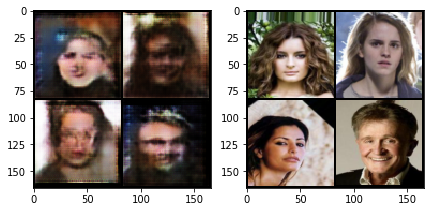

[0/2][750/2380]	Disc/Dec Trains: 239.0/734.0	Loss_D: 1.3728	Loss_Dec: 3.1170	Aux F1: 0.8408	Loss_Enc: 18848.4985	D(x): 0.4791	D(G(z)): 0.3377
[0/2][1000/2380]	Disc/Dec Trains: 322.0/978.0	Loss_D: 1.3740	Loss_Dec: 3.1182	Aux F1: 0.8416	Loss_Enc: 18228.6147	D(x): 0.4408	D(G(z)): 0.2914


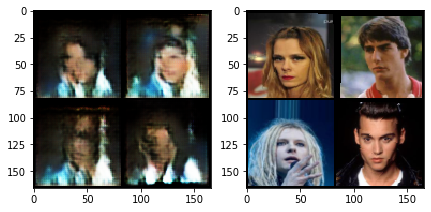

[0/2][1250/2380]	Disc/Dec Trains: 398.0/1226.0	Loss_D: 1.3782	Loss_Dec: 3.1151	Aux F1: 0.8426	Loss_Enc: 18270.4407	D(x): 0.4699	D(G(z)): 0.2108
[0/2][1500/2380]	Disc/Dec Trains: 479.0/1472.0	Loss_D: 1.3767	Loss_Dec: 3.1211	Aux F1: 0.8433	Loss_Enc: 18210.8063	D(x): 0.6014	D(G(z)): 0.2348


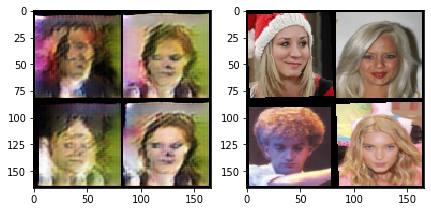

[0/2][1750/2380]	Disc/Dec Trains: 567.0/1718.0	Loss_D: 1.3762	Loss_Dec: 3.1227	Aux F1: 0.8441	Loss_Enc: 18014.1954	D(x): 0.6520	D(G(z)): 0.2055
[0/2][2000/2380]	Disc/Dec Trains: 651.0/1962.0	Loss_D: 1.3785	Loss_Dec: 3.1223	Aux F1: 0.8449	Loss_Enc: 17437.0058	D(x): 0.5241	D(G(z)): 0.2359


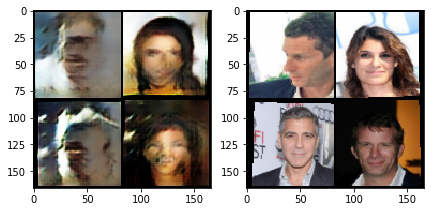

[0/2][2250/2380]	Disc/Dec Trains: 737.0/2207.0	Loss_D: 1.3789	Loss_Dec: 3.1238	Aux F1: 0.8458	Loss_Enc: 16582.3541	D(x): 0.6099	D(G(z)): 0.2379


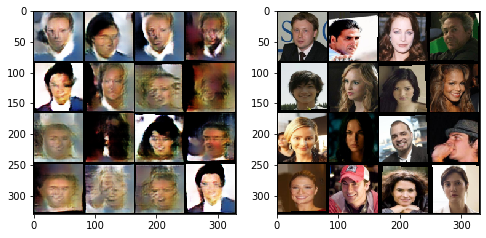

[1/2][0/2380]	Disc/Dec Trains: 1.0/1.0	Loss_D: 1.4573	Loss_Dec: 3.0494	Aux F1: 0.8562	Loss_Enc: 8910.1182	D(x): 0.5025	D(G(z)): 0.2567
Interrupting... Saving model...
Copying file://./vaegan_basic_80a.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

|
Operation completed over 1 objects/172.7 MiB.                              

In [0]:
train(net, n_epochs=2, train_loader=train_loader, margin=0.43, plot_images=500)

[0/2][0/2380]	Disc/Dec Trains: 1.0/1.0	Loss_D: 1.5715	Loss_Dec: 2.8549	Aux F1: 0.8523	Loss_Enc: 9622.1543	D(x): 0.4787	D(G(z)): 0.2704
[0/2][250/2380]	Disc/Dec Trains: 80.0/249.0	Loss_D: 1.3812	Loss_Dec: 3.1139	Aux F1: 0.8577	Loss_Enc: 8896.2872	D(x): 0.5214	D(G(z)): 0.2650
[0/2][500/2380]	Disc/Dec Trains: 164.0/495.0	Loss_D: 1.3850	Loss_Dec: 3.1137	Aux F1: 0.8575	Loss_Enc: 8877.9155	D(x): 0.5239	D(G(z)): 0.2802
[0/2][750/2380]	Disc/Dec Trains: 247.0/743.0	Loss_D: 1.3782	Loss_Dec: 3.1339	Aux F1: 0.8578	Loss_Enc: 8626.4460	D(x): 0.4908	D(G(z)): 0.2731


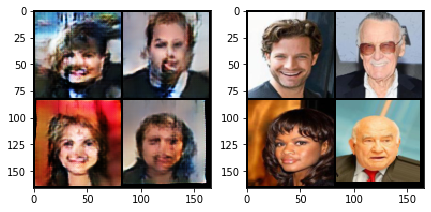

[0/2][1000/2380]	Disc/Dec Trains: 331.0/991.0	Loss_D: 1.3718	Loss_Dec: 3.1575	Aux F1: 0.8583	Loss_Enc: 8335.5051	D(x): 0.4722	D(G(z)): 0.2482
[0/2][1250/2380]	Disc/Dec Trains: 408.0/1241.0	Loss_D: 1.3729	Loss_Dec: 3.1644	Aux F1: 0.8589	Loss_Enc: 8136.2836	D(x): 0.4991	D(G(z)): 0.2797
[0/2][1500/2380]	Disc/Dec Trains: 485.0/1488.0	Loss_D: 1.3718	Loss_Dec: 3.1695	Aux F1: 0.8595	Loss_Enc: 7972.0827	D(x): 0.5547	D(G(z)): 0.2666


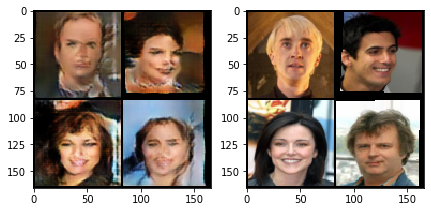

[0/2][1750/2380]	Disc/Dec Trains: 561.0/1735.0	Loss_D: 1.3713	Loss_Dec: 3.1711	Aux F1: 0.8599	Loss_Enc: 7840.7265	D(x): 0.5316	D(G(z)): 0.2600
[0/2][2000/2380]	Disc/Dec Trains: 633.0/1985.0	Loss_D: 1.3704	Loss_Dec: 3.1706	Aux F1: 0.8604	Loss_Enc: 7726.9235	D(x): 0.5910	D(G(z)): 0.2047
[0/2][2250/2380]	Disc/Dec Trains: 706.0/2232.0	Loss_D: 1.3697	Loss_Dec: 3.1744	Aux F1: 0.8609	Loss_Enc: 7577.6126	D(x): 0.5435	D(G(z)): 0.2541


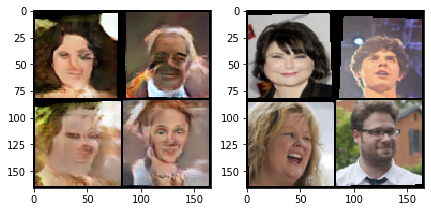

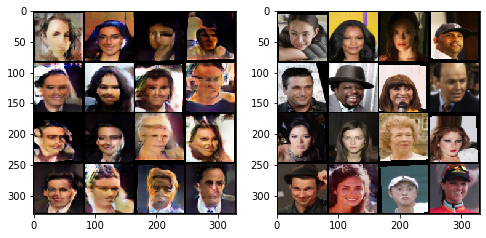

[1/2][0/2380]	Disc/Dec Trains: 0.0/1.0	Loss_D: 1.1094	Loss_Dec: 3.6268	Aux F1: 0.8624	Loss_Enc: 5216.4204	D(x): 0.5936	D(G(z)): 0.2175
[1/2][250/2380]	Disc/Dec Trains: 63.0/250.0	Loss_D: 1.3768	Loss_Dec: 3.1904	Aux F1: 0.8670	Loss_Enc: 5135.3146	D(x): 0.4932	D(G(z)): 0.2663
[1/2][500/2380]	Disc/Dec Trains: 124.0/498.0	Loss_D: 1.3685	Loss_Dec: 3.2427	Aux F1: 0.8680	Loss_Enc: 4285.8483	D(x): 0.6036	D(G(z)): 0.2141
[1/2][750/2380]	Disc/Dec Trains: 172.0/748.0	Loss_D: 1.3708	Loss_Dec: 3.2500	Aux F1: 0.8683	Loss_Enc: 3893.5435	D(x): 0.4886	D(G(z)): 0.2670


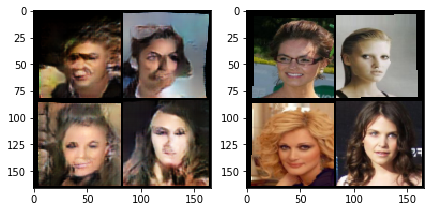

[1/2][1000/2380]	Disc/Dec Trains: 218.0/997.0	Loss_D: 1.3706	Loss_Dec: 3.2676	Aux F1: 0.8685	Loss_Enc: 3708.3462	D(x): 0.5502	D(G(z)): 0.2183
[1/2][1250/2380]	Disc/Dec Trains: 266.0/1247.0	Loss_D: 1.3796	Loss_Dec: 3.2535	Aux F1: 0.8690	Loss_Enc: 3579.5483	D(x): 0.5343	D(G(z)): 0.2680
[1/2][1500/2380]	Disc/Dec Trains: 314.0/1496.0	Loss_D: 1.3852	Loss_Dec: 3.2462	Aux F1: 0.8693	Loss_Enc: 3460.8787	D(x): 0.5060	D(G(z)): 0.3037


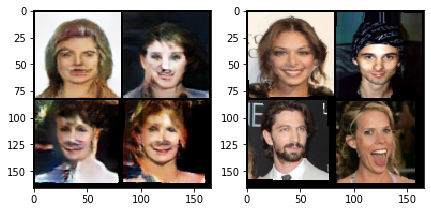

[1/2][1750/2380]	Disc/Dec Trains: 362.0/1745.0	Loss_D: 1.3856	Loss_Dec: 3.2412	Aux F1: 0.8694	Loss_Enc: 3386.7479	D(x): 0.5626	D(G(z)): 0.2342
[1/2][2000/2380]	Disc/Dec Trains: 407.0/1994.0	Loss_D: 1.3861	Loss_Dec: 3.2481	Aux F1: 0.8696	Loss_Enc: 3293.8083	D(x): 0.5185	D(G(z)): 0.2824
[1/2][2250/2380]	Disc/Dec Trains: 449.0/2244.0	Loss_D: 1.3857	Loss_Dec: 3.2553	Aux F1: 0.8698	Loss_Enc: 3260.4287	D(x): 0.4982	D(G(z)): 0.3139


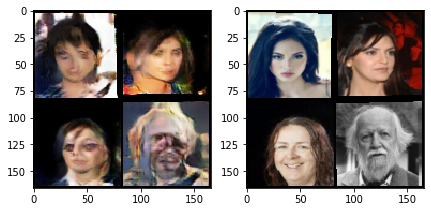

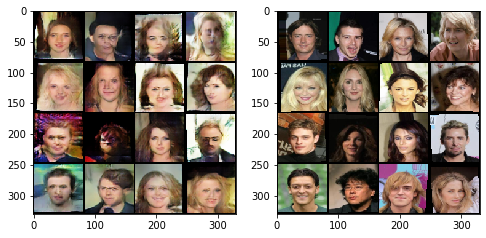

Copying file://./vaegan_basic_80a.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

|
Operation completed over 1 objects/172.7 MiB.                                    
Copying file://./vaegan_basic_80a_disc.pt [Content-Type=application/octet-stream]...
\
Operation completed over 1 objects/60.4 MiB.                             

In [0]:
train(net, n_epochs=2, train_loader=train_loader, margin=0.43, plot_images=750) 

[0/2][0/2380]	Disc/Dec Trains: 1.0/1.0	Loss_D: 1.6630	Loss_Dec: 3.1066	Aux F1: 0.8665	Loss_Enc: 1906.5750	D(x): 0.4497	D(G(z)): 0.3235
[0/2][250/2380]	Disc/Dec Trains: 29.0/251.0	Loss_D: 1.4514	Loss_Dec: 3.3453	Aux F1: 0.8759	Loss_Enc: 2307.1828	D(x): 0.5341	D(G(z)): 0.2504
[0/2][500/2380]	Disc/Dec Trains: 56.0/501.0	Loss_D: 1.4516	Loss_Dec: 3.3387	Aux F1: 0.8765	Loss_Enc: 2340.5172	D(x): 0.4979	D(G(z)): 0.2928
[0/2][750/2380]	Disc/Dec Trains: 82.0/751.0	Loss_D: 1.4587	Loss_Dec: 3.3286	Aux F1: 0.8766	Loss_Enc: 2364.5031	D(x): 0.4969	D(G(z)): 0.2797
[0/2][1000/2380]	Disc/Dec Trains: 109.0/1001.0	Loss_D: 1.4610	Loss_Dec: 3.3283	Aux F1: 0.8767	Loss_Enc: 2328.8953	D(x): 0.4750	D(G(z)): 0.3341


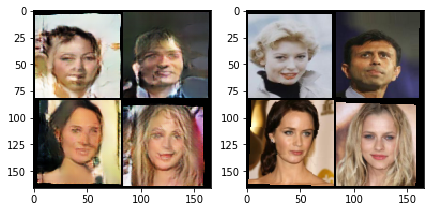

[0/2][1250/2380]	Disc/Dec Trains: 136.0/1249.0	Loss_D: 1.4653	Loss_Dec: 3.3194	Aux F1: 0.8770	Loss_Enc: 2328.1967	D(x): 0.5588	D(G(z)): 0.3090
[0/2][1500/2380]	Disc/Dec Trains: 164.0/1499.0	Loss_D: 1.4638	Loss_Dec: 3.3246	Aux F1: 0.8770	Loss_Enc: 2324.1341	D(x): 0.4838	D(G(z)): 0.3185
[0/2][1750/2380]	Disc/Dec Trains: 189.0/1749.0	Loss_D: 1.4657	Loss_Dec: 3.3315	Aux F1: 0.8771	Loss_Enc: 2302.9965	D(x): 0.4190	D(G(z)): 0.3380
[0/2][2000/2380]	Disc/Dec Trains: 213.0/1998.0	Loss_D: 1.4703	Loss_Dec: 3.3154	Aux F1: 0.8772	Loss_Enc: 2299.8918	D(x): 0.5478	D(G(z)): 0.2778


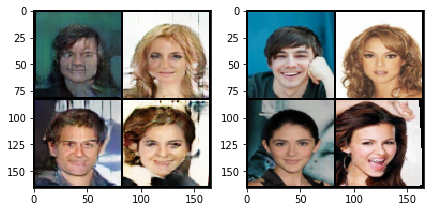

[0/2][2250/2380]	Disc/Dec Trains: 246.0/2248.0	Loss_D: 1.4698	Loss_Dec: 3.3090	Aux F1: 0.8773	Loss_Enc: 2270.6045	D(x): 0.4916	D(G(z)): 0.3329


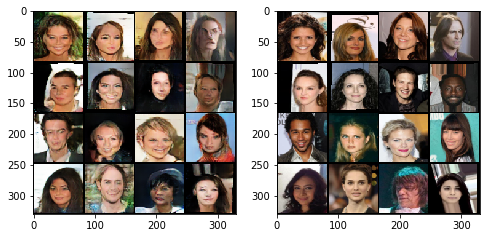

[1/2][0/2380]	Disc/Dec Trains: 0.0/1.0	Loss_D: 1.4798	Loss_Dec: 3.2539	Aux F1: 0.8801	Loss_Enc: 2096.2573	D(x): 0.4862	D(G(z)): 0.3091
[1/2][250/2380]	Disc/Dec Trains: 64.0/250.0	Loss_D: 1.4382	Loss_Dec: 3.3171	Aux F1: 0.8768	Loss_Enc: 2189.1514	D(x): 0.4676	D(G(z)): 0.3267
[1/2][500/2380]	Disc/Dec Trains: 112.0/498.0	Loss_D: 1.4452	Loss_Dec: 3.3140	Aux F1: 0.8770	Loss_Enc: 2290.7373	D(x): 0.5028	D(G(z)): 0.3154
[1/2][750/2380]	Disc/Dec Trains: 160.0/744.0	Loss_D: 1.4469	Loss_Dec: 3.3403	Aux F1: 0.8769	Loss_Enc: 2314.9209	D(x): 0.5395	D(G(z)): 0.2745
[1/2][1000/2380]	Disc/Dec Trains: 205.0/993.0	Loss_D: 1.4480	Loss_Dec: 3.3429	Aux F1: 0.8768	Loss_Enc: 2358.5751	D(x): 0.5859	D(G(z)): 0.2200


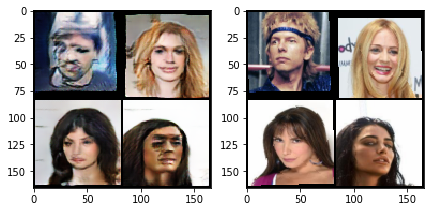

[1/2][1250/2380]	Disc/Dec Trains: 245.0/1242.0	Loss_D: 1.4495	Loss_Dec: 3.3444	Aux F1: 0.8770	Loss_Enc: 2361.0468	D(x): 0.4653	D(G(z)): 0.2680
[1/2][1500/2380]	Disc/Dec Trains: 287.0/1491.0	Loss_D: 1.4499	Loss_Dec: 3.3437	Aux F1: 0.8772	Loss_Enc: 2381.3971	D(x): 0.5898	D(G(z)): 0.2297
[1/2][1750/2380]	Disc/Dec Trains: 327.0/1739.0	Loss_D: 1.4507	Loss_Dec: 3.3542	Aux F1: 0.8773	Loss_Enc: 2389.7058	D(x): 0.5247	D(G(z)): 0.3581
[1/2][2000/2380]	Disc/Dec Trains: 364.0/1989.0	Loss_D: 1.4505	Loss_Dec: 3.3590	Aux F1: 0.8775	Loss_Enc: 2383.1918	D(x): 0.4441	D(G(z)): 0.3422


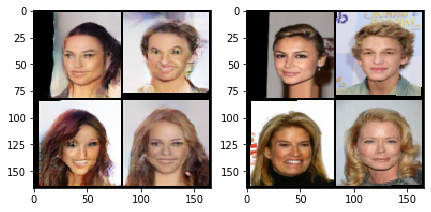

[1/2][2250/2380]	Disc/Dec Trains: 402.0/2238.0	Loss_D: 1.4498	Loss_Dec: 3.3662	Aux F1: 0.8776	Loss_Enc: 2398.1874	D(x): 0.4577	D(G(z)): 0.3748


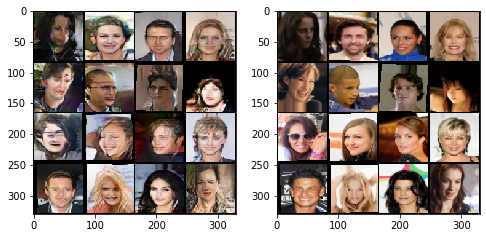

Copying file://./vaegan_basic_80a.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

|
Operation completed over 1 objects/172.7 MiB.                                    
Copying file://./vaegan_basic_80a_disc.pt [Content-Type=application/octet-stream]...
\
Operation completed over 1 objects/60.4 MiB.                             

In [17]:
train(net, n_epochs=2, train_loader=train_loader, margin=0.43, plot_images=1000)

In [18]:
train(net, n_epochs=2, train_loader=train_loader, margin=0.43, plot_images=1200) 

[0/2][0/2380]	Disc/Dec Trains: 0.0/1.0	Loss_D: 1.4580	Loss_Dec: 3.5033	Aux F1: 0.8728	Loss_Enc: 2174.7600	D(x): 0.5082	D(G(z)): 0.3025
Interrupting... Saving model...
Copying file://./vaegan_basic_80a.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/
Operation completed over 1 objects/172.7 MiB.                              

In [0]:
lr_encoder.step()
lr_decoder.step()
lr_discriminator.step()
# lr_encoder.step()
# lr_decoder.step()
# lr_discriminator.step()
# lr_encoder.step()
# lr_decoder.step()
# lr_discriminator.step()
#
for pg in optimizer_encoder.param_groups:
    print(pg['lr'])

for pg in optimizer_decoder.param_groups:
    print(pg['lr'])

for pg in optimizer_discriminator.param_groups:
    print(pg['lr'])    

4.21875e-05
4.21875e-05
5.120000000000001e-05


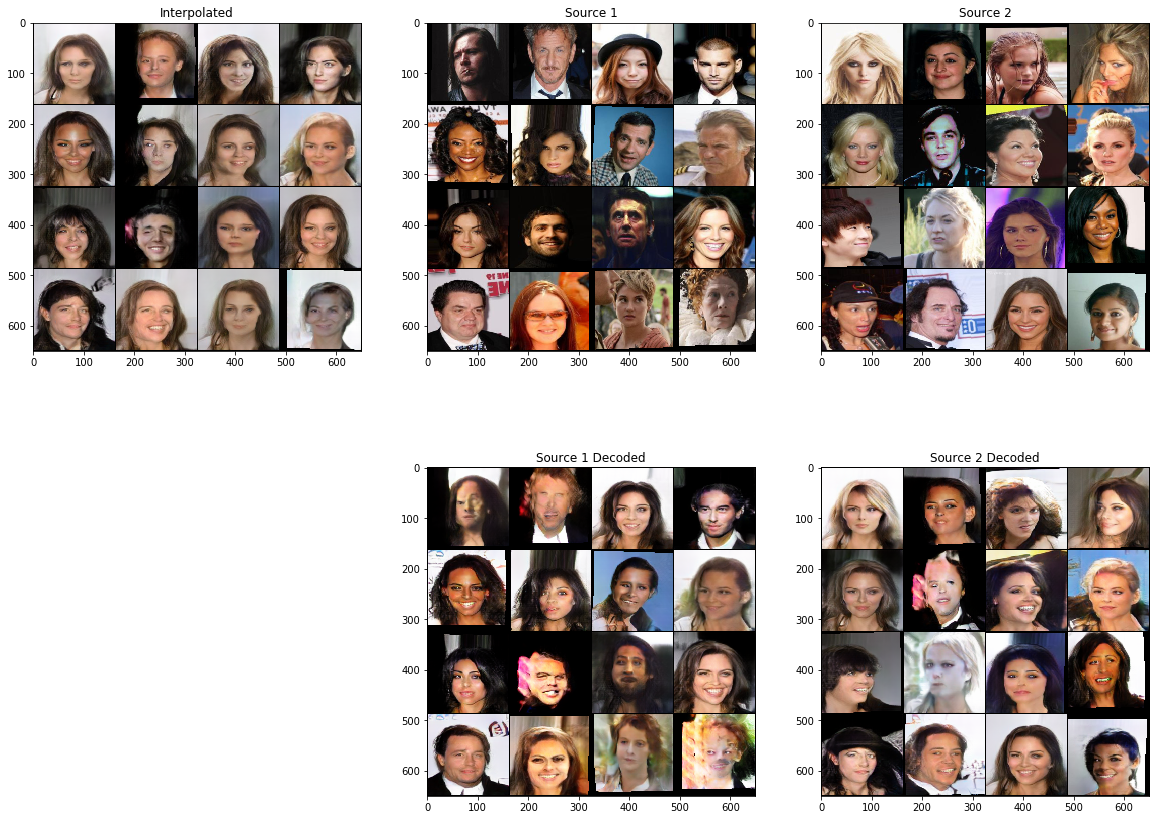

In [0]:
## Interpolation
with torch.no_grad():
    net.eval()
    inputs, _ = next(iter(train_loader))
    inputs = inputs.cuda()

    # encode the data
    mus, log_variances = net.encoder(inputs)
    
    batch_1 = mus[:16]
    batch_2 = mus[16:32]

    new_mu = (batch_1 + batch_2) / 2.

    # interpolate
    fake = net.decoder(torch.cat([new_mu, batch_1, batch_2], axis=0))
    fake = (fake * 0.5) + 0.5
    inputs = (inputs * 0.5) + 0.5

    fig, ax = plt.subplots(2, 3, figsize=(20,15))
    ax[0,0].imshow(np.transpose(vutils.make_grid(fake.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
    ax[0,0].set_title("Interpolated")
    ax[0,1].imshow(np.transpose(vutils.make_grid(inputs.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
    ax[0,1].set_title("Source 1")
    ax[0,2].imshow(np.transpose(vutils.make_grid(inputs.detach().cpu()[16:32], nrow=4, padding=2, normalize=True),(1,2,0)))
    ax[0,2].set_title("Source 2")
    ax[1,0].axis("off")
    ax[1,1].imshow(np.transpose(vutils.make_grid(fake.detach().cpu()[16:32], nrow=4, padding=2, normalize=True),(1,2,0)))
    ax[1,1].set_title("Source 1 Decoded")
    ax[1,2].imshow(np.transpose(vutils.make_grid(fake.detach().cpu()[32:48], nrow=4, padding=2, normalize=True),(1,2,0)))
    ax[1,2].set_title("Source 2 Decoded")
    plt.show()   

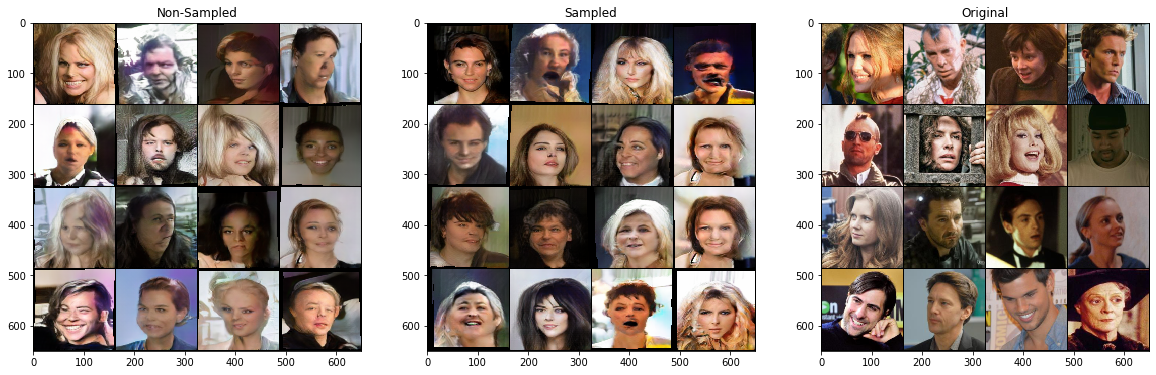

In [0]:
with torch.no_grad():
    net.train()
    inputs, _ = next(iter(test_loader))
    inputs = inputs.cuda()
    
    fake, out_labels, aux_out, out_layer, mus, variances = net(inputs, output_samples=True)
    
    train_batch = inputs.shape[0]
    fake = (fake * 0.5) + 0.5
    decoded = fake[:train_batch]
    # out_layer_original = fake[train_batch:-train_batch]
    sampled = fake[train_batch:]
    
    fig, ax = plt.subplots(1, 3, figsize=(20,60))
    ax[0].imshow(np.transpose(vutils.make_grid(decoded.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
    ax[0].set_title("Non-Sampled")
    ax[1].imshow(np.transpose(vutils.make_grid(sampled.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
    ax[1].set_title("Sampled")
    ax[2].imshow(np.transpose(vutils.make_grid(inputs.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
    ax[2].set_title("Original")
    plt.show()   

# print("Code mean:", code.mean().item())
# print("Code max:", code.max().item())
# print("Code min:", code.min().item())
# print("Code var:", code.var().item())
# print()

# # print("SCode mean:", code_s.mean().item())
# # print("SCode max:", code_s.max().item())
# # print("SCode min:", code_s.min().item())
# # print("SCode var:", code_s.var().item())
# # print()

# print("Logvar mean:", logvar.mean().item())
# print("Logvar var:", logvar.var().item())
# print("Logvar Exp:", logvar.exp().mean().item())

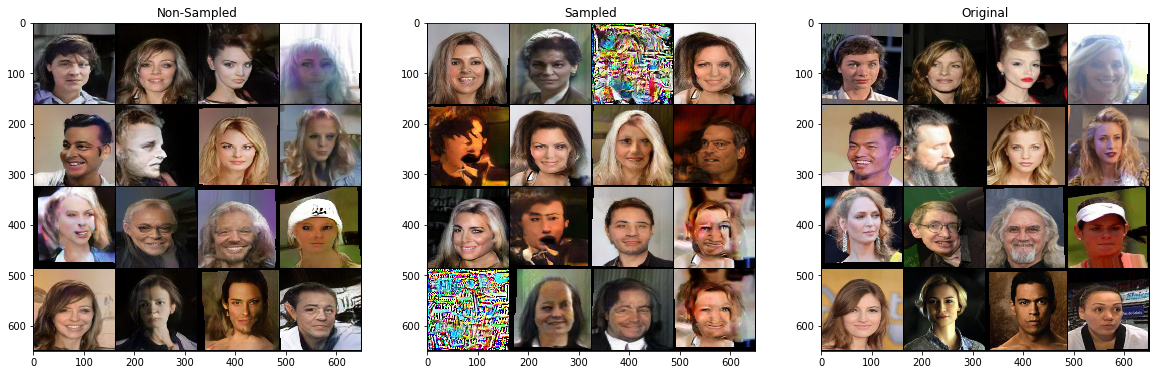

In [0]:
with torch.no_grad():
    net.train()
    inputs, _ = next(iter(train_loader))
    inputs = inputs.cuda()
    
    fake, out_labels, aux_out, out_layer, mus, variances = net(inputs, output_samples=True)
    
    train_batch = inputs.shape[0]
    
    out_layer_predicted = fake[:train_batch]
    out_layer_sampled = fake[train_batch:]
    fake = (fake * 0.5) + 0.5
    fig, ax = plt.subplots(1, 3, figsize=(20,60))
    ax[0].imshow(np.transpose(vutils.make_grid(out_layer_predicted.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
    ax[0].set_title("Non-Sampled")
    ax[1].imshow(np.transpose(vutils.make_grid(out_layer_sampled.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
    ax[1].set_title("Sampled")
    ax[2].imshow(np.transpose(vutils.make_grid(inputs.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
    ax[2].set_title("Original")
    plt.show()   

# print("Code mean:", code.mean().item())
# print("Code max:", code.max().item())
# print("Code min:", code.min().item())
# print("Code var:", code.var().item())
# print()

# # print("SCode mean:", code_s.mean().item())
# # print("SCode max:", code_s.max().item())
# # print("SCode min:", code_s.min().item())
# # print("SCode var:", code_s.var().item())
# # print()

# print("Logvar mean:", logvar.mean().item())
# print("Logvar var:", logvar.var().item())
# print("Logvar Exp:", logvar.exp().mean().item())